In [116]:
import tqdm, json, os, re, string, pprint, itertools, seaborn, collections, numpy as np, csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

from sklearn.model_selection import GridSearchCV


In [68]:
judgments = []
signatures = []

def read_file(file_path):
    print ("Processing file" + file_path)
    with open (file_path) as file:
        json_content = json.load(file)
        item_count = 0
        for item in tqdm.tqdm(json_content):
            judgment = []
            if item['courtType'] in ['COMMON', 'SUPREME']:
                courtCases = item['courtCases']
                signatures_for_judgment = []
                for courtCase in courtCases:
                    signature = courtCase['caseNumber']
                    signatures_for_judgment.append(signature)
                signatures.append(signatures_for_judgment)
                item_count += 1
                text_content = re.sub("<.*?>", "", item["textContent"])
                text_content = text_content.replace('-\n', '')
                word_content = text_content.split()
                topicSpecificPunctuation = '„”–§…«»'
                translator = str.maketrans('', '', string.punctuation+topicSpecificPunctuation)

                for word in word_content:
                    word = word.translate(translator).lower()
                    if len(word)>0:
                        judgment.append(word)
                judgments.append(judgment)

In [69]:
def read_all_judgments_from_2018():
        for filename in os.listdir("../data_filtered_2/"):
            read_file("../data_filtered_2/" + filename)

In [70]:
read_all_judgments_from_2018()

 45%|████▌     | 45/100 [00:00<00:00, 447.34it/s]

Processing file../data_filtered_2/judgments-3163.json
Processing file../data_filtered_2/judgments-3168.json


 30%|███       | 30/100 [00:00<00:00, 288.06it/s]

Processing file../data_filtered_2/judgments-3164.json


 39%|███▉      | 39/100 [00:00<00:00, 385.02it/s]

Processing file../data_filtered_2/judgments-3171.json


 26%|██▌       | 26/100 [00:00<00:00, 253.45it/s]

Processing file../data_filtered_2/judgments-3165.json


 31%|███       | 31/100 [00:00<00:00, 303.54it/s]

Processing file../data_filtered_2/judgments-3167.json


 29%|██▉       | 29/100 [00:00<00:00, 287.73it/s]

Processing file../data_filtered_2/judgments-3169.json


 42%|████▏     | 34/81 [00:00<00:00, 338.94it/s]

Processing file../data_filtered_2/judgments-3173.json


 36%|███▌      | 36/100 [00:00<00:00, 351.98it/s]

Processing file../data_filtered_2/judgments-3172.json


 37%|███▋      | 37/100 [00:00<00:00, 349.40it/s]

Processing file../data_filtered_2/judgments-3166.json


 31%|███       | 31/100 [00:00<00:00, 281.66it/s]

Processing file../data_filtered_2/judgments-3170.json


100%|██████████| 100/100 [00:00<00:00, 268.91it/s]


In [71]:
signatures_flatten = [item for sublist in signatures for item in sublist]
signatures_categories = []
for signature in signatures_flatten:
    splited = signature.split(" ")
    signatures_categories.append(splited[1])
print(signatures_categories)

['Ca', 'C', 'K', 'P', 'GC', 'GC', 'Gz', 'Gz', 'GC', 'Ga', 'C', 'AmE', 'AmE', 'U', 'U', 'U', 'U', 'C', 'K', 'K', 'U', 'U', 'K', 'GC', 'GC', 'GC', 'GC', 'Ka', 'AUa', 'AUa', 'P', 'Pa', 'W', 'GC', 'U', 'K', 'Ga', 'K', 'AKa', 'AUa', 'GC', 'C', 'C', 'K', 'C', 'Kp', 'U', 'U', 'Ca', 'Ca', 'K', 'Cz', 'Cz', 'RC', 'U', 'K', 'Ca', 'Pa', 'Pa', 'K', 'K', 'Ca', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'C', 'W', 'K', 'RCa', 'W', 'AUa', 'AUa', 'K', 'W', 'W', 'W', 'C', 'U', 'K', 'K', 'AUa', 'AUa', 'AUa', 'AUa', 'Gz', 'Gz', 'Gz', 'C', 'C', 'C', 'K', 'C', 'RC', 'Ca', 'RCa', 'Pa', 'Pa', 'Pa', 'C', 'C', 'C', 'Ga', 'P', 'C', 'Ns', 'K', 'Ka', 'Ka', 'C', 'K', 'P', 'Gz', 'Ns', 'Ns', 'K', 'Ns', 'P', 'P', 'APz', 'Gz', 'P', 'RCa', 'Pa', 'Pa', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'Ns', 'P', 'U', 'C', 'U', 'C', 'K', 'GC', 'W', 'Ka', 'U', 'C', 'AKa', 'C', 'K', 'K', 'GC', 'GC', 'K', 'P', 'P', 'Gz', 'U', 'U', 'U', 'Ga', 'Ca', 'U', 'U', 'P', 'C', 'P', 'U', 'U', 'U', 'K', 'P', 'P', 'P', 'U

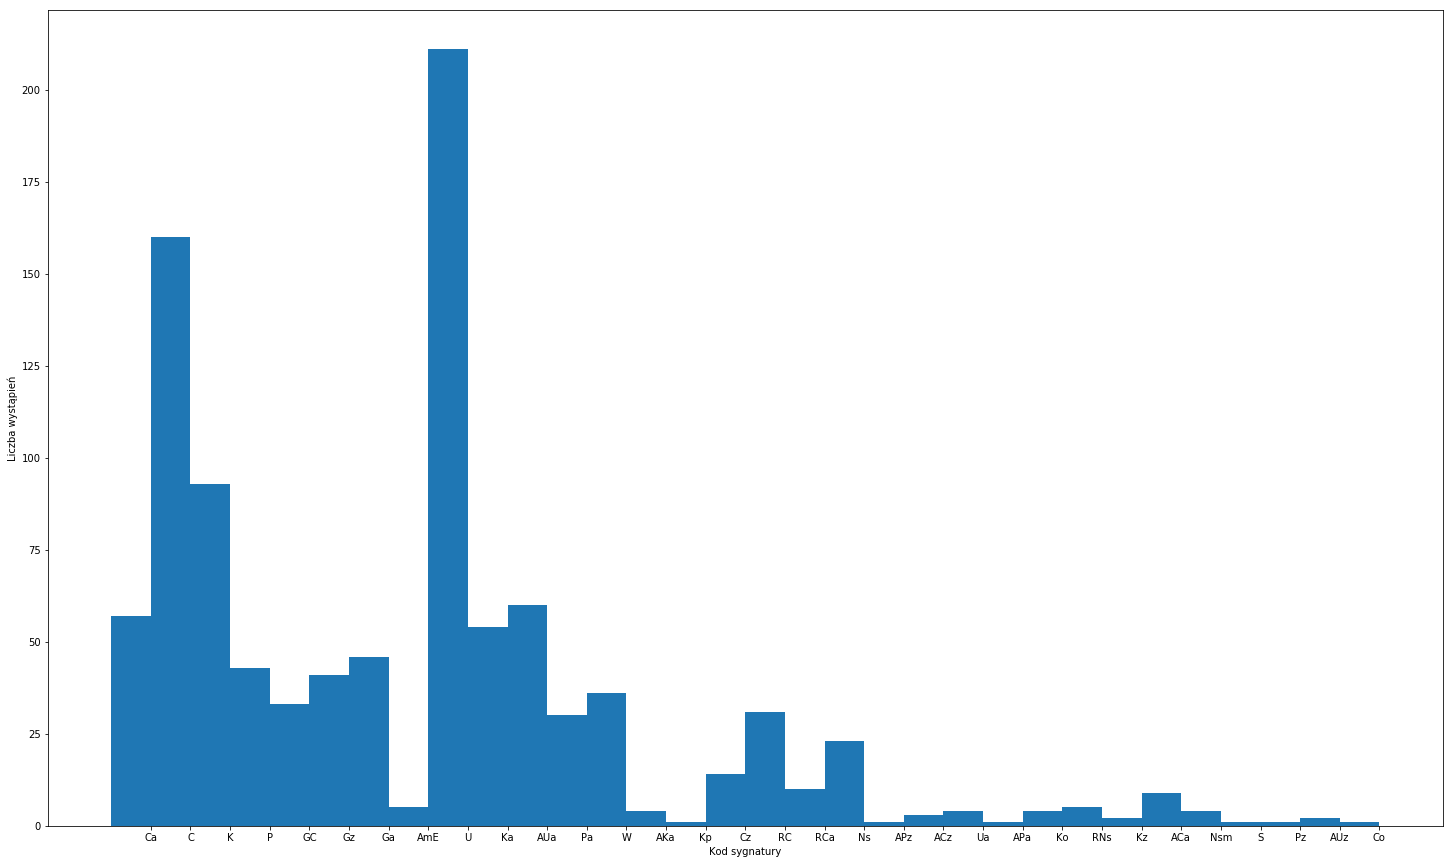

In [72]:
counter = collections.Counter(signatures_categories)

def plot_histogram_from_counter(cnt, initial_values):
    counter_len = len(cnt.keys())
    plt.figure(figsize=(25,15))
    plt.xlabel('Kod sygnatury')
    plt.ylabel('Liczba wystąpień')
    labels, values = zip(*collections.Counter(initial_values).items())
    indexes = np.arange(counter_len)
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

plot_histogram_from_counter(counter, signatures_categories)

In [73]:
judgments_and_signatures = zip(judgments, signatures)
judgments_and_signatures_list = list(judgments_and_signatures)
print(judgments_and_signatures_list[5])



(['sygn', 'akt', 'vi', 'gc', '43415', 'wyrok', 'w', 'imieniu', 'rzeczypospolitej', 'polskiej', 'dnia', '02', 'stycznia', '2018', 'roku', 'sąd', 'rejonowy', 'w', 'gdyni', 'vi', 'wydział', 'gospodarczy', 'w', 'składzie', 'przewodniczący', 'ssr', 'justyna', 'supińska', 'protokolant', 'sekr', 'sąd', 'natalia', 'freyer', 'po', 'rozpoznaniu', 'w', 'dniu', '18', 'grudnia', '2017', 'roku', 'w', 'gdyni', 'na', 'rozprawie', 'sprawy', 'z', 'powództwa', 'spółki', 'z', 'ograniczona', 'odpowiedzialnością', 'z', 'siedzibą', 'w', 'w', 'przeciwko', 'p', 'd', 'o', 'zapłatę', 'i', 'zasądza', 'od', 'pozwanego', 'p', 'd', 'na', 'rzecz', 'powoda', 'spółki', 'z', 'ograniczoną', 'odpowiedzialnością', 'z', 'siedzibą', 'w', 'w', 'kwotę', '64', '61010', 'złotych', 'sześćdziesiąt', 'cztery', 'tysiące', 'sześćset', 'dziesięć', 'złotych', 'dziesięć', 'groszy', 'wraz', 'z', 'odsetkami', 'ustawowymi', 'liczonymi', 'za', 'okres', 'od', 'dnia', '31', 'stycznia', '2012', 'roku', 'do', 'dnia', '31', 'grudnia', '2015', 'r

In [74]:
signatures_regexes = {
    re.compile(r'A?C.*') : 'sprawy cywilne',
    re.compile(r'A?U.*') : 'sprawy z zakresu ubezpieczenia społecznego',
    re.compile(r'A?K.*') : 'sprawy karne',
    re.compile(r'G.*') : 'sprawy gospodarcze',
    re.compile(r'A?P.*') : 'sprawy w zakresie prawa pracy',
    re.compile(r'R.*') : 'sprawy w zakresie prawa rodzinnego',
    re.compile(r'W.*') : 'sprawy o wykroczenia',
    re.compile(r'Am.*') : 'sprawy w zakresie prawa konkurencji'
}

new_signatures = []
not_matching_signatures = []

judgments_and_signatures_list_after_transformation = []

def match_signature_to_code(code):
    for judg_regex in signatures_regexes.keys():
        if (re.match(judg_regex, code)):
            return signatures_regexes[judg_regex]
    return None

for pair in judgments_and_signatures_list:
    code = " ".join(pair[1]).split(" ")[1]
    res = match_signature_to_code(code)
    judgments_and_signatures_list_after_transformation.append((pair[0], res))
    if res is None:
        not_matching_signatures.append(code)


judgments_and_signatures_list_after_transformation[:10][1]

(['sygn',
  'akt',
  'x',
  'c',
  '199217',
  'uzasadnienie',
  'powód',
  'gmina',
  'o',
  'w',
  'sprzeciwie',
  'od',
  'orzeczenia',
  'samorządowego',
  'kolegium',
  'odwoławczego',
  'z',
  'dnia',
  '30',
  '03',
  '2017r',
  'wniósł',
  'o',
  'ustalenie',
  'że',
  'zmiana',
  'stawki',
  'procentowej',
  'z',
  'tytułu',
  'użytkowania',
  'wieczystego',
  'udziału',
  'wynoszącego',
  '42510',
  '000',
  'związanego',
  'z',
  'własnością',
  'lokali',
  'numer',
  'w',
  'działkach',
  'numer',
  'położonych',
  'przy',
  'ul',
  'w',
  'o',
  'będącego',
  'w',
  'użytkowaniu',
  'wieczystym',
  'pozwanych',
  'b',
  'z',
  'i',
  'a',
  'z',
  '1',
  'jest',
  'uzasadniona',
  'i',
  'wynosi',
  '3',
  'powód',
  'wywodził',
  'żądanie',
  'z',
  'umowy',
  'użytkowania',
  'wieczystego',
  'udziału',
  'w',
  'nieruchomości',
  'o',
  'której',
  'mowa',
  'w',
  'sprzeciwie',
  'wskazał',
  'że',
  'zmiana',
  'stawki',
  'opłaty',
  'z',
  'tytułu',
  'użytkowania',

In [75]:
print(not_matching_signatures)

['Ns', 'Ns', 'Ns', 'Ns', 'Ns', 'Ns', 'Ns', 'Ns', 'Ns', 'Nsm', 'S', 'Ns', 'Ns', 'Ns', 'Ns', 'Nsm', 'Ns', 'Ns', 'Ns', 'Ns', 'Ns', 'Ns', 'Nsm', 'Ns', 'Ns', 'Nsm', 'Ns', 'Ns']


In [76]:
judgments_signatures = list(filter(lambda x: x[1] is not None, 
                                   judgments_and_signatures_list_after_transformation))

In [77]:
len(judgments_signatures)

962

In [78]:
judgments_signatures = list(judgments_signatures)
print(judgments_signatures[:1])

print(type(judgments_signatures[0][0]))

[(['uzasadnienie', 'powód', 'sp', 'z', 'oo', 'sp', 'k', 'z', 'siedzibą', 'w', 'p', 'wniósł', 'o', 'zwolnienie', 'spod', 'egzekucji', 'administracyjnej', 'prawa', 'majątkowego', 'przysługującego', 'powodowi', 'w', 'postaci', 'wierzytelności', 'z', 'tytułu', 'nienależnie', 'pobranego', 'podatku', 'akcyzowego', 'za', 'miesiące', 'luty', 'marzec', 'kwiecień', 'maj', 'wrzesień', 'i', 'październik', '2011', 'r', 'określonego', 'w', 'decyzji', 'naczelnika', 'urzędy', 'celnego', 'w', 'z', 'z', 'dnia', '6', 'lutego', '2013', 'r', 'nr', '91104141213dn', 'oraz', 'dyrektora', 'izby', 'celnej', 'w', 'r', 'z', 'dnia', '8', 'kwietnia', '2014', 'r', 'nr', '241314', 'która', 'został', 'stwierdzona', 'prawomocnym', 'wyrokiem', 'wojewódzkiego', 'sądu', 'administracyjnego', 'w', 'g', 'z', 'dnia', '6', 'lipca', '2016', 'r', 'sygn', 'akt', 'i', 'sago', '18616', 'w', 'postaci', 'kosztów', 'egzekucyjnych', 'w', 'kwocie', '861498', 'złotych', 'wynikających', 'z', 'egzekucji', 'ww', 'nienależnie', 'pobranego', 

In [79]:
cases_types = [case[1] for case in judgments_signatures]
cases_type_counter = collections.Counter(cases_types)
cases_type_counter

Counter({'sprawy cywilne': 244,
         'sprawy gospodarcze': 120,
         'sprawy karne': 158,
         'sprawy o wykroczenia': 36,
         'sprawy w zakresie prawa konkurencji': 5,
         'sprawy w zakresie prawa pracy': 76,
         'sprawy w zakresie prawa rodzinnego': 46,
         'sprawy z zakresu ubezpieczenia społecznego': 277})

In [80]:
filtered_judgments_signatures = []
for pair in judgments_signatures:
    if pair[1] != 'sprawy w zakresie prawa konkurencji':
        filtered_judgments_signatures.append(pair)

In [81]:
cases_types = [case[1] for case in filtered_judgments_signatures]
cases_type_counter = collections.Counter(cases_types)
cases_type_counter

Counter({'sprawy cywilne': 244,
         'sprawy gospodarcze': 120,
         'sprawy karne': 158,
         'sprawy o wykroczenia': 36,
         'sprawy w zakresie prawa pracy': 76,
         'sprawy w zakresie prawa rodzinnego': 46,
         'sprawy z zakresu ubezpieczenia społecznego': 277})

In [82]:
most_common_words = []

with open('filteredRank.csv') as file:
    idx, number_of_rows = 0, 20
    csv_reader = csv.reader(file)
    for row in csv_reader:
        word = ",".join(row).split(",")[1]
        most_common_words.append(word)
        idx+=1
        if idx >= number_of_rows:
            break


In [83]:
most_common_words

['na',
 'do',
 'nie',
 'że',
 'dnia',
 'się',
 'art',
 'od',
 'przez',
 'sąd',
 'roku',
 'pracy',
 'za',
 'jest',
 'oraz',
 'zł',
 'tym',
 'to',
 'sądu',
 'co']

In [84]:
def filter_decision(decision):
    try:
        idx = decision.index('uzasadnienie')
        new_decision = decision[idx+1:]
        new_decision = [word for word in new_decision 
                    if (not word.isdigit() and len(word) > 1 and word not in most_common_words)]
        return new_decision
    except ValueError:
        pass
    

In [85]:
filtered_judgments_signatures_v2 = []

for pair in filtered_judgments_signatures:
    decision = pair[0]
    new_decision = filter_decision(decision)
    if new_decision:
        filtered_judgments_signatures_v2.append((new_decision, pair[1]))

In [86]:
X = []
Y = []
for pair in filtered_judgments_signatures_v2:
    X.append(pair[0])
    Y.append(pair[1])
    
print (len(X))
print (len(Y))

777
777


In [87]:
print (len(X))
new_X = []
for sublist in X:
    words = " ".join(sublist)
    new_X.append(words)
    

777


In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(new_X, Y, test_size=0.25)

X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.3)
print (len(X_train))
print (len(Y_train))
print (len(X_validation))
print (len(Y_validation))
print (len(X_test))
print (len(Y_test))

407
407
175
175
195
195


In [89]:
category_list = [
    'sprawy cywilne',
    'sprawy z zakresu ubezpieczenia społecznego',
    'sprawy karne',
    'sprawy gospodarcze',
    'sprawy w zakresie prawa pracy',
    'sprawy w zakresie prawa rodzinnego',
    'sprawy o wykroczenia',
    'sprawy w zakresie prawa konkurencji'
]

In [90]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']


In [91]:
Y_train_mapped = np.array([category_list.index(category) for category in Y_train])

Y_train_mapped = Y_train_mapped.reshape(-1, 1)

In [92]:
Y_test_mapped = np.array([category_list.index(category) for category in Y_test])

Y_test_mapped = Y_test_mapped.reshape(-1, 1)

In [93]:
Y_val_mapped = np.array([category_list.index(category) for category in Y_validation])

Y_val_mapped = Y_val_mapped.reshape(-1, 1)

In [94]:
# TODO: LabelEncoding, tf-idf, train/valid/split, train classifier, do the same with transformed words

In [95]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_validation = vectorizer.transform(X_validation)

In [96]:
# one_hot_encoder = LabelBinarizer()
# Y_train_encoded = one_hot_encoder.fit_transform(Y_train_mapped)
# Y_test_encoded = one_hot_encoder.transform(Y_test_mapped)

In [97]:
pprint.pprint(X_train.shape)

(407, 45656)


In [98]:
Y_train_mapped[2]

array([1])

In [107]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters,
                       scoring='%s_macro' % score)
    print (X_train.shape)
    print (Y_train_mapped.shape)
    clf.fit(X_train, Y_train_mapped.flatten())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_predicted_on_validation = clf.predict(X_validation)
    print(classification_report(Y_val_mapped, y_predicted_on_validation))
    print()

# Tuning hyper-parameters for precision

(407, 45656)
(407, 1)


/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.044 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.044 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.044 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.044 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.346 (+/-0.007) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.044 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.910 (+/-0.039) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.346 (+/-0.007) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.901 (+/-0.029) for {'C': 1, 'kernel': 'linear'}
0.910 (+/-0.039) for {'C': 10, 'kernel': 'linear'}
0.910 (+/-0.039) for {'C': 100, 'kernel': 'linear'}
0.910 (+/-0.039) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

In [108]:
# best params:
# {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [110]:
clf = svm.SVC(C=1000, gamma=0.001, kernel='rbf')
clf.fit(X_train, Y_train_mapped)

/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [111]:
X_test = vectorizer.transform(X_test)

In [112]:
y_predicted = clf.predict(X_test)

In [ ]:
# y_test_encoded = one_hot_encoder.transform(y_test)

In [115]:
pprint.pprint(accuracy_score(Y_test_mapped, y_predicted))
print(classification_report(Y_test_mapped, y_predicted, target_names=category_list))

0.88205128205128203
                                            precision    recall  f1-score   support

                            sprawy cywilne       0.78      0.94      0.86        54
sprawy z zakresu ubezpieczenia społecznego       1.00      0.94      0.97        53
                              sprawy karne       1.00      0.87      0.93        31
                        sprawy gospodarcze       0.82      0.64      0.72        28
             sprawy w zakresie prawa pracy       0.91      0.83      0.87        12
        sprawy w zakresie prawa rodzinnego       1.00      1.00      1.00         8
                      sprawy o wykroczenia       0.67      0.89      0.76         9

                               avg / total       0.89      0.88      0.88       195



/home/grzegorz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 7, does not match size of target_names, 8
  .format(len(labels), len(target_names))


In [117]:
pprint.pprint(precision_recall_fscore_support(Y_test_mapped, y_predicted, average='micro'))
pprint.pprint(precision_recall_fscore_support(Y_test))

(0.88205128205128203, 0.88205128205128203, 0.88205128205128203, None)
